In [1]:
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   pandas.plotting import register_matplotlib_converters
from   pprint import pprint
from   tensorflow.keras import Sequential
from   tensorflow.keras.backend import clear_session
from   tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from   tensorflow.keras.losses import mean_squared_error as mse
from   tensorflow.keras.optimizers import Adam
from   tensorflow.keras.optimizers.schedules import ExponentialDecay
import yfinance as yf

warnings.filterwarnings('ignore')
register_matplotlib_converters()
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

In [2]:
STOCKS = [
    '^GSPC', 'AAXN', 'ABMD', 'ANET', 'AYX', 'BIDU', 'DDOG', 'DOCU', 
    'EDIT', 'ETSY', 'FSLY', 'GH', 'ISRG', 'LYV', 'MDB', 'MELI', 'MTCH', 
    'NVCR', 'OKTA', 'PANW', 'PINS', 'PTON', 'ROKU', 'SHOP', 'TDOC', 
    'TEAM', 'TREX', 'TTD', 'TTWO', 'VEEV', 'ZEN', 'ZG']
tickers = ' '.join(STOCKS)

In [3]:
data = yf.download(tickers, start='2010-01-01')
data.head()

[*********************100%***********************]  32 of 32 completed


Adj Close                                                     ...  \
                AAXN  ABMD ANET AYX       BIDU DDOG DOCU EDIT ETSY FSLY  ...   
Date                                                                     ...   
2010-01-04      4.65  8.74  NaN NaN  41.002998  NaN  NaN  NaN  NaN  NaN  ...   
2010-01-05      4.70  8.53  NaN NaN  40.590000  NaN  NaN  NaN  NaN  NaN  ...   
2010-01-06      5.84  8.40  NaN NaN  41.250000  NaN  NaN  NaN  NaN  NaN  ...   
2010-01-07      5.66  8.40  NaN NaN  40.463001  NaN  NaN  NaN  NaN  NaN  ...   
2010-01-08      5.56  8.23  NaN NaN  40.426998  NaN  NaN  NaN  NaN  NaN  ...   

           Volume                                                          
             SHOP TDOC TEAM    TREX TTD     TTWO VEEV ZEN  ZG       ^GSPC  
Date                                                                       
2010-01-04    NaN  NaN  NaN  427200 NaN  3666400  NaN NaN NaN  3991400000  
2010-01-05    NaN  NaN  NaN  618800 NaN  4442300  NaN NaN NaN  2491020000  
2010-01-06    NaN  NaN  NaN  343600 NaN  2829400  NaN NaN NaN  4972660000  
2010-01-07    NaN  NaN  NaN  147200 NaN  2655500  NaN NaN NaN  5270680000  
2010-01-08    NaN  NaN  NaN  193200 NaN  2143400  NaN NaN NaN  4389590000  

[5 rows x 192 columns]

In [4]:
def rename(names):
    return f'{names[1]}_{names[0].replace(" ", "_")}'

In [5]:
data.columns = [rename(x) for x in data.columns]
data.head()

,AAXN_Adj_Close,ABMD_Adj_Close,ANET_Adj_Close,AYX_Adj_Close,BIDU_Adj_Close,DDOG_Adj_Close,DOCU_Adj_Close,EDIT_Adj_Close,ETSY_Adj_Close,FSLY_Adj_Close,...,SHOP_Volume,TDOC_Volume,TEAM_Volume,TREX_Volume,TTD_Volume,TTWO_Volume,VEEV_Volume,ZEN_Volume,ZG_Volume,^GSPC_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,4.65,8.74,NaN,NaN,41.002998,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,427200,NaN,3666400,NaN,NaN,NaN,3991400000
2010-01-05,4.70,8.53,NaN,NaN,40.590000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,618800,NaN,4442300,NaN,NaN,NaN,2491020000
2010-01-06,5.84,8.40,NaN,NaN,41.250000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,343600,NaN,2829400,NaN,NaN,NaN,4972660000
2010-01-07,5.66,8.40,NaN,NaN,40.463001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,147200,NaN,2655500,NaN,NaN,NaN,5270680000
2010-01-08,5.56,8.23,NaN,NaN,40.426998,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,193200,NaN,2143400,NaN,NaN,NaN,4389590000


In [6]:
keep = [x for x in list(data) if 'Adj' in x] 
data = data[keep]
data.rename(columns={x: x.replace('_Adj_Close', '') for x in list(data)},
            inplace=True)
data.fillna(method='bfill', inplace=True)
data.head()

,AAXN,ABMD,ANET,AYX,BIDU,DDOG,DOCU,EDIT,ETSY,FSLY,...,SHOP,TDOC,TEAM,TREX,TTD,TTWO,VEEV,ZEN,ZG,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,4.65,8.74,55.0,15.5,41.002998,37.549999,39.73,18.200001,30.0,24.25,...,17.0,19.0,21.0,5.0600,30.1,10.40,37.16,13.43,11.153727,1132.989990
2010-01-05,4.70,8.53,55.0,15.5,40.590000,37.549999,39.73,18.200001,30.0,24.25,...,17.0,19.0,21.0,5.0275,30.1,10.47,37.16,13.43,11.153727,1136.520020
2010-01-06,5.84,8.40,55.0,15.5,41.250000,37.549999,39.73,18.200001,30.0,24.25,...,17.0,19.0,21.0,4.9050,30.1,10.44,37.16,13.43,11.153727,1137.140015
2010-01-07,5.66,8.40,55.0,15.5,40.463001,37.549999,39.73,18.200001,30.0,24.25,...,17.0,19.0,21.0,4.8875,30.1,10.39,37.16,13.43,11.153727,1141.689941
2010-01-08,5.56,8.23,55.0,15.5,40.426998,37.549999,39.73,18.200001,30.0,24.25,...,17.0,19.0,21.0,4.9175,30.1,10.42,37.16,13.43,11.153727,1144.979980


In [7]:
data = data / data.iloc[0, :]
data = np.log(data)
original_dates = data.index
data.index = range(data.shape[0])
data.head()

,AAXN,ABMD,ANET,AYX,BIDU,DDOG,DOCU,EDIT,ETSY,FSLY,...,SHOP,TDOC,TEAM,TREX,TTD,TTWO,VEEV,ZEN,ZG,^GSPC
0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.010695,-0.024321,0.0,0.0,-0.010123,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.006444,0.0,0.006708,0.0,0.0,0.0,0.003111
2,0.227864,-0.039679,0.0,0.0,0.006006,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.031111,0.0,0.003839,0.0,0.0,0.0,0.003656
3,0.196557,-0.039679,0.0,0.0,-0.013257,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.034686,0.0,-0.000962,0.0,0.0,0.0,0.007649
4,0.178731,-0.060124,0.0,0.0,-0.014147,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.028566,0.0,0.001921,0.0,0.0,0.0,0.010527


In [8]:
data.tail()

,AAXN,ABMD,ANET,AYX,BIDU,DDOG,DOCU,EDIT,ETSY,FSLY,...,SHOP,TDOC,TEAM,TREX,TTD,TTWO,VEEV,ZEN,ZG,^GSPC
2631,3.015429,3.372294,1.415588,2.276374,1.090622,0.793649,1.403698,0.496102,1.056864,0.876327,...,3.872866,2.313369,2.129988,3.169702,2.542047,2.592092,1.818402,1.813123,1.692191,1.010884
2632,2.982854,3.366901,1.383791,2.339197,1.102272,0.836204,1.407340,0.578279,1.064711,0.940973,...,3.927850,2.312952,2.135180,3.165792,2.572815,2.608726,1.814113,1.817970,1.704495,1.011478
2633,2.964275,3.381516,1.377208,2.356340,1.099189,0.837818,1.401903,0.569302,1.156776,0.965611,...,3.947844,2.361499,2.106686,3.159017,2.573803,2.618308,1.808262,1.800040,1.715361,1.005813
2634,2.990341,3.372019,1.371965,2.374996,1.099189,0.863075,1.443642,0.600827,1.166271,1.105735,...,3.974512,2.378278,2.173452,3.193984,2.593915,2.607947,1.860896,1.844572,1.691035,1.012287
2635,3.022678,3.363818,1.366184,2.356034,1.101219,0.870686,1.434689,0.634889,1.216099,1.141000,...,3.981703,2.344232,2.161296,3.200929,2.611705,2.623623,1.861649,1.847276,1.727704,1.016585


In [9]:
for c in list(data):
    print(f'{c}: {(1 * pd.isnull(data[c])).sum()}')

AAXN: 0
ABMD: 0
ANET: 0
AYX: 0
BIDU: 0
DDOG: 0
DOCU: 0
EDIT: 0
ETSY: 0
FSLY: 0
GH: 0
ISRG: 0
LYV: 0
MDB: 0
MELI: 0
MTCH: 0
NVCR: 0
OKTA: 0
PANW: 0
PINS: 0
PTON: 0
ROKU: 0
SHOP: 0
TDOC: 0
TEAM: 0
TREX: 0
TTD: 0
TTWO: 0
VEEV: 0
ZEN: 0
ZG: 0
^GSPC: 0


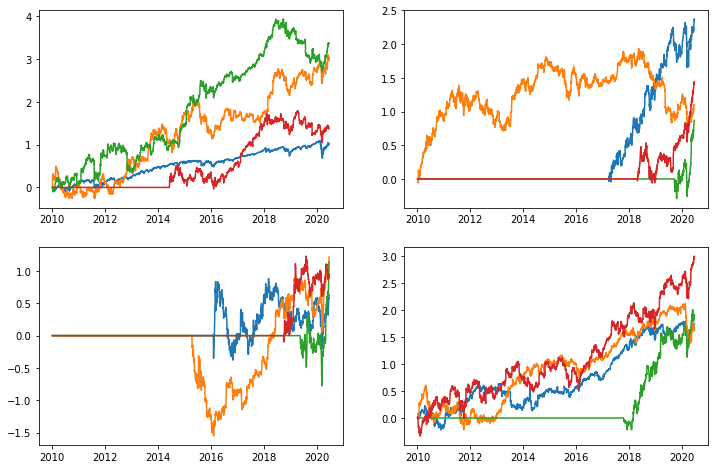

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.plot(original_dates, data[STOCKS[:4]])

plt.subplot(222)
plt.plot(original_dates, data[STOCKS[4:8]]);

plt.subplot(223)
plt.plot(original_dates, data[STOCKS[8:12]]);

plt.subplot(224)
plt.plot(original_dates, data[STOCKS[12:16]]);

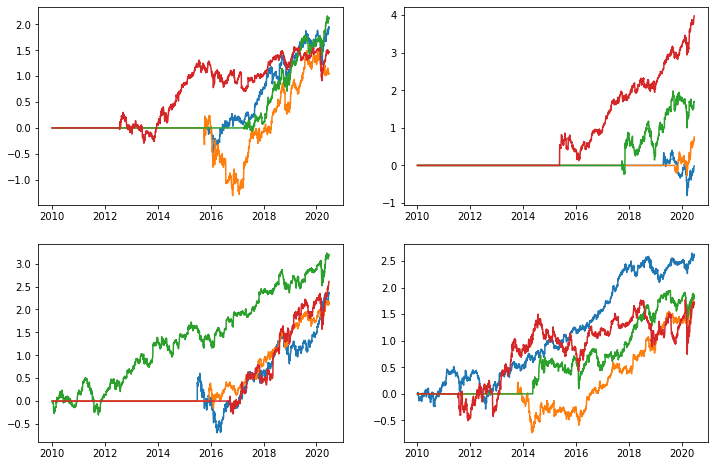

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.plot(original_dates, data[STOCKS[16:20]])

plt.subplot(222)
plt.plot(original_dates, data[STOCKS[20:24]]);

plt.subplot(223)
plt.plot(original_dates, data[STOCKS[24:28]]);

plt.subplot(224)
plt.plot(original_dates, data[STOCKS[28:]]);

In [12]:
N_HISTORY = 250 # days of history to use to predict the next value
N_FUTURE  = [5, 10, 20, 40] # value at n days ahead to predict

In [13]:
def get_Xy_matrices(data, i, n_history, n_future):
    start_i = i - n_history + 1
    y_is = [i + x for x in n_future]
    X = data.loc[start_i:i, :]
    ys = []
    for i in y_is:
        try:
            y = data.loc[i, :]
        except KeyError:
            y = data.loc[0, :]
            y[y == 0] = np.nan
        ys.append(y)
    ys = [pd.DataFrame(y).T for y in ys]
    for y, t in zip(ys, n_future):
        y.rename(columns={x: f'{x}_t{t}' for x in list(y)}, inplace=True)
    for y in ys:
        y.index = [i]
    ys = pd.concat(ys, axis=1)
    return X, ys

In [16]:
X_test, y_test = get_Xy_matrices(data.copy(), 300, 10, [5, 10, 20, 40])

In [17]:
y_test

,AAXN_t5,ABMD_t5,ANET_t5,AYX_t5,BIDU_t5,DDOG_t5,DOCU_t5,EDIT_t5,ETSY_t5,FSLY_t5,...,SHOP_t40,TDOC_t40,TEAM_t40,TREX_t40,TTD_t40,TTWO_t40,VEEV_t40,ZEN_t40,ZG_t40,^GSPC_t40
340,-0.194002,0.49095,0.0,0.0,1.106636,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.403487,0.0,0.44197,0.0,0.0,0.0,0.180534


In [18]:
def get_Xy_tensors(data, n_history, n_future):
    X_tensor, y_tensor = [], []
    max_i = data.index.max()
    for i in range(n_history + 1, max_i - max(n_future)):
        print(f'{100 * i / max_i:.2f}%', end='\r')
        X, ys = get_Xy_matrices(data, i, n_history, n_future)
        X_tensor.append(X.values)
        y_tensor.append(ys.values)
    return np.array(X_tensor), np.array(y_tensor)

In [19]:
X, ys = get_Xy_tensors(data.copy(), N_HISTORY, N_FUTURE)

In [20]:
X.shape # records (0 is earliest), timesteps, features

(2344, 250, 32)

In [21]:
np.isnan(X).sum(), X.max()

(0, 3.940781709351052)

In [22]:
ys.shape # records, 1, responses

(2344, 1, 128)

In [23]:
np.isnan(ys).sum(), ys.max()

(0, 3.9745116301525916)

In [24]:
class RNN:
    def __init__(self, X, ys, fields, responses, rnn_cell='LSTM', fraction_train=0.7):
        self.X = X
        self.ys = ys
        self.fields = fields
        self.responses = responses
        self.rnn_cell = LSTM if rnn_cell == 'LSTM' else GRU
        assert len(fields) == X.shape[2], 'fields and X[2] do not match'
        assert len(responses) == ys.shape[2], \
            'responses and ys[2] do not match'
        assert X.shape[0] == ys.shape[0], 'X and ys do not match'
        self._split_train_valid_test(fraction_train)
        
    def _split_train_valid_test(self, fraction_train):
        n = self.X.shape[0]
        n_train = int(round(fraction_train * n))
        n_valid = (n - n_train) // 2
        n_test = n - n_train - n_valid
        self.X_train = self.X[:n_train, :, :]
        self.ys_train = self.ys[:n_train, :, :]
        self.X_valid = self.X[n_train:(n_train + n_valid), :, :]
        self.ys_valid = self.ys[n_train:(n_train + n_valid), :, :]
        self.X_test = self.X[(n_train + n_valid):, :, :]
        self.ys_test = self.ys[(n_train + n_valid):, :, :]
        print('Train:', self.X_train.shape, self.ys_train.shape)
        print('Valid:', self.X_valid.shape, self.ys_valid.shape)
        print('Test:', self.X_test.shape, self.ys_test.shape)
        
    def train(self, stock, params, n_ahead):
        y_idx = [i for i, resp in enumerate(self.responses) if stock in resp and resp.endswith(f't{n_ahead}')]
        self.y_train = self.ys_train[:, 0, y_idx].reshape(-1)#, len(y_idx))
        self.y_valid = self.ys_valid[:, 0, y_idx].reshape(-1)#, len(y_idx))
        self.y_test = self.ys_test[:, 0, y_idx].reshape(-1)#, len(y_idx))
        print('y:', self.y_train.shape, self.y_valid.shape, self.y_test.shape)
        self._create_mod(params)
        print(self.mod.summary())
        self._compile_mod(params)
        self._fit_mod(params)
        return self.history
        
    def _create_mod(self, params):
        mod = Sequential()
        mod.add(
            self.rnn_cell(
                units=params['RNN_UNITS'], 
                return_sequences=True, 
                dropout=params['DROPOUT'],
                recurrent_dropout=params['RECURRENT_DROPOUT'],
                input_shape=(
                    self.X_train.shape[1], self.X_train.shape[2])))
        if params['RNN_LAYERS'] > 2:
            for layer in range(params['RNN_LAYERS'] - 1):
                mod.add(
                    self.rnn_cell(
                        units=params['RNN_UNITS'], 
                        return_sequences=True, 
                        dropout=params['DROPOUT'],
                        recurrent_dropout=params['RECURRENT_DROPOUT']))
        mod.add(
            self.rnn_cell(units=params['RNN_UNITS'], 
                          dropout=params['DROPOUT'], 
                          recurrent_dropout=params['RECURRENT_DROPOUT']))
        mod.add(Dense(units=1)) # predict all future dates?
        mod.add(Dropout(params['DROPOUT']))
        self.mod = mod
        
    def _compile_mod(self, params):
        print('Compiling model...')
        learning_rate = ExponentialDecay(
            initial_learning_rate=params['ETA'],
            decay_steps=params['EPOCHS'] // 10,
            decay_rate=params['DECAY'])
        adam = Adam(learning_rate=learning_rate, #params['ETA'], #learning_rate, 
                    beta_1=params['BETA_1'], 
                    beta_2=params['BETA_2'], 
                    epsilon=params['EPSILON'],
                    decay=params['DECAY'])
        self.mod.compile(
            loss='mean_squared_error', optimizer=adam)
        
    def _fit_mod(self, params, verbose=0):
        print('Fitting...')
        start = datetime.now()
        history = self.mod.fit(self.X_train,
                               self.y_train,
                               validation_data=(self.X_valid, self.y_valid),
                               epochs=params['EPOCHS'],
                               batch_size=params['BATCH'],
                               verbose=verbose)
        elapsed = datetime.now() - start
        print(f'Time: {elapsed}')
        self.history = history

In [25]:
rnn = RNN(X, ys, list(data), list(y_test))

Train: (1641, 250, 32) (1641, 1, 128)
Valid: (351, 250, 32) (351, 1, 128)
Test: (352, 250, 32) (352, 1, 128)


In [29]:
params = {
        'RNN_UNITS': 50, #np.random.choice(range(40, 100)),
        'RNN_LAYERS': 3, #np.random.choice(range(5, 7)),
        'DROPOUT': np.random.uniform(low=0.1, high=0.6),
        'RECURRENT_DROPOUT': np.random.uniform(low=0, high=0.6),
        'ETA': 10 ** np.random.uniform(low=-6, high=-2),
        'BETA_1': np.random.uniform(low=0.85, high=0.95),
        'BETA_2': np.random.uniform(low=0.9, high=0.9999),
        'EPSILON': np.random.choice([1e-06, 1e-07, 1e-08]),
        'DECAY': 10 ** np.random.uniform(low=-4, high=-2),
        'EPOCHS': 3,
        'BATCH': np.random.choice([32, 64, 128, 256])}

In [30]:
pprint(params)

{'BATCH': 64,
 'BETA_1': 0.8778274918559663,
 'BETA_2': 0.9963477993900833,
 'DECAY': 0.0010289465187873922,
 'DROPOUT': 0.30667474075320666,
 'EPOCHS': 3,
 'EPSILON': 1e-07,
 'ETA': 0.0023204845638455855,
 'RECURRENT_DROPOUT': 0.32446689549373875,
 'RNN_LAYERS': 3,
 'RNN_UNITS': 50}


In [31]:
history = rnn.train('MDB', params, 5)

y: (1641,) (351,) (352,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 250, 50)           16600     
_________________________________________________________________
lstm_8 (LSTM)                (None, 250, 50)           20200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 250, 50)           20200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
Total params: 77,251
Trainable params: 77,251
Non-trainable params: 0
_________________________

In [32]:
history.history

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan]}